In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [48]:
data = pd.read_csv('src/static/data/historical.csv', index_col="date")
data = data.sort_values(by='date')

In [49]:
data.head()

,id,timestamp,open,high,low,close,volume,adjclose,symbol,currency,created_at
date,,,,,,,,,,,
2024-01-02 10:30:00 UTC,1,1704205800,102.250000,102.620003,100.589996,101.529999,9020900,99.724220,TSM,USD,2025-05-11 20:04:00
2024-01-03 10:30:00 UTC,2,1704292200,100.339996,101.250000,99.660004,100.169998,6650600,98.388412,TSM,USD,2025-05-11 20:04:00
2024-01-04 10:30:00 UTC,3,1704378600,99.529999,100.440002,99.120003,99.129997,7996700,97.366905,TSM,USD,2025-05-11 20:04:00
2024-01-05 10:30:00 UTC,4,1704465000,99.000000,100.639999,98.800003,99.610001,7344900,97.838364,TSM,USD,2025-05-11 20:04:00
2024-01-08 10:30:00 UTC,5,1704724200,100.629997,102.790001,100.500000,102.239998,12455600,100.421585,TSM,USD,2025-05-11 20:04:00


In [50]:
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]
train_original = train.copy()

In [51]:
result = adfuller(train["close"])

d = 0
while result[1] > 0.05:
    train["close"] = train["close"].diff()
    d += 1
    result = adfuller(train["close"].dropna())

print(f"Serie de entrenamiento es estacionaria después de {d} diferenciaciones.")


Serie de entrenamiento es estacionaria después de 1 diferenciaciones.


/tmp/ipykernel_15559/3138587217.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["close"] = train["close"].diff()


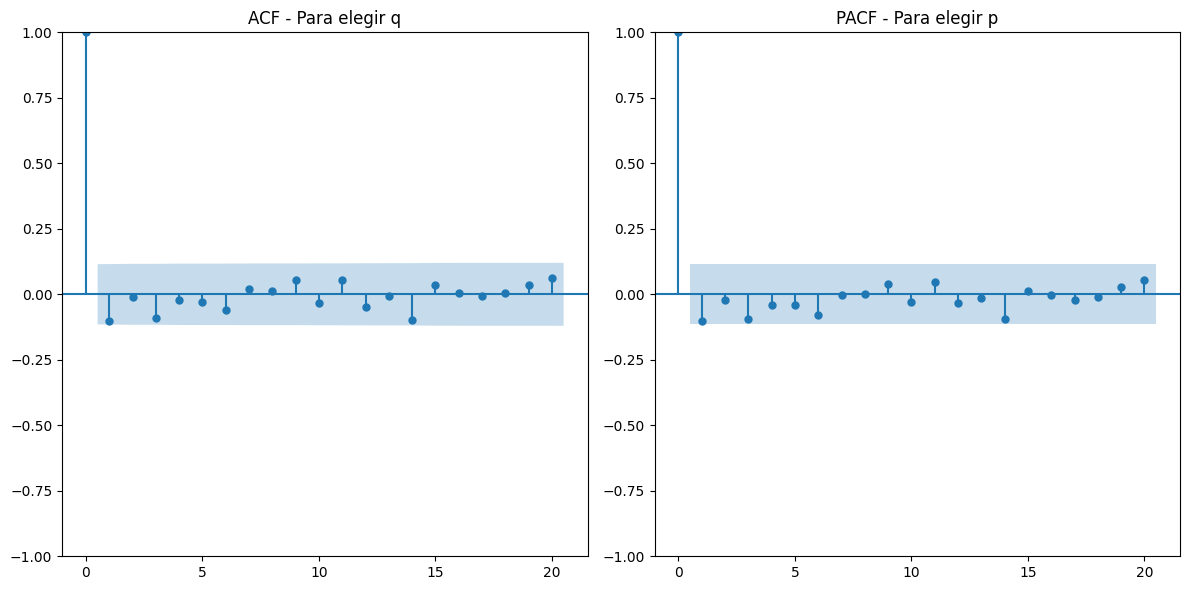

In [52]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Asegúrate de usar la serie diferenciada y sin NaN
series_stationary = train["close"].dropna()

plt.figure(figsize=(12, 6))

# ACF para q
plt.subplot(1, 2, 1)
plot_acf(series_stationary, lags=20, ax=plt.gca())
plt.title("ACF - Para elegir q")

# PACF para p
plt.subplot(1, 2, 2)
plot_pacf(series_stationary, lags=20, ax=plt.gca(), method='ywm')
plt.title("PACF - Para elegir p")

plt.tight_layout()
plt.show()


In [53]:
p = 1
q = 1
model = ARIMA(train["close"].dropna(), order=(p, d, q))
fitted_model = model.fit()

/home/ibarraortizdev/miniconda3/envs/PIV/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ibarraortizdev/miniconda3/envs/PIV/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ibarraortizdev/miniconda3/envs/PIV/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/home/ibarraortizdev/miniconda3/envs/PIV/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/ibarraortizdev/miniconda3/envs/PIV/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


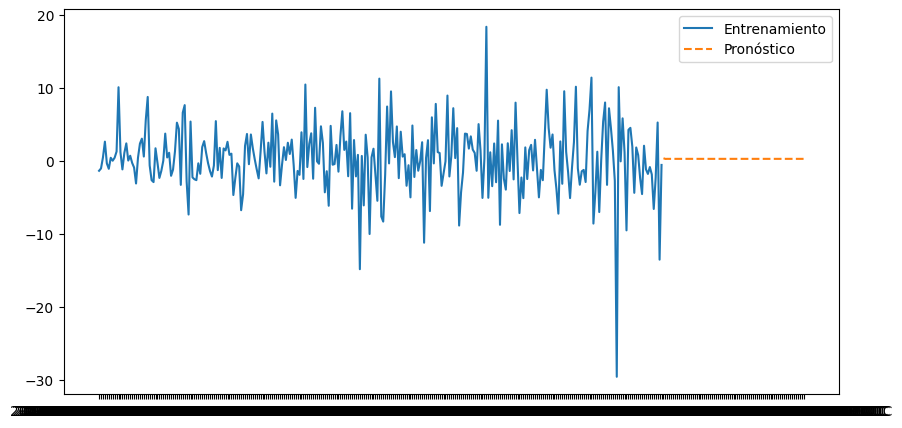

In [54]:
forecast = fitted_model.forecast(steps=len(test))

plt.figure(figsize=(10, 5))
plt.plot(train["close"].dropna(), label='Entrenamiento')
plt.plot(test.index, forecast, label='Pronóstico', linestyle='--')
plt.legend()
plt.show()

In [55]:
plt.close()

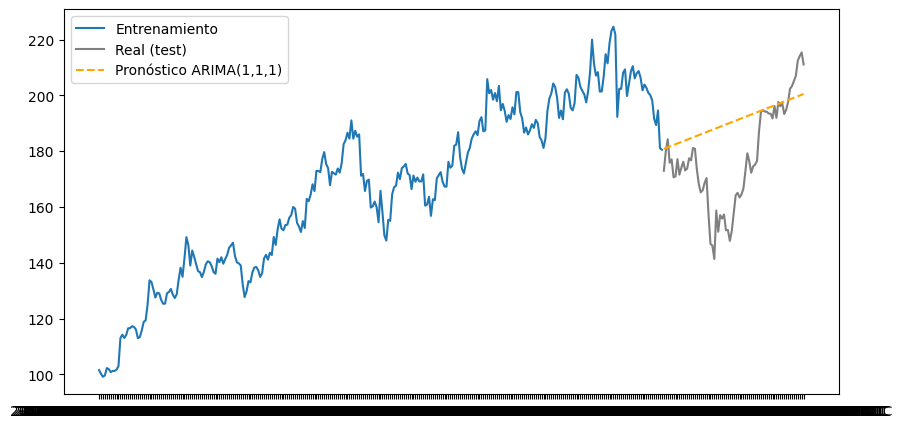

In [56]:
# Último valor original antes de la predicción
last_value = train_original["close"].iloc[-1]  # asegúrate de tener una copia de los datos originales

# Reconstruir los valores a partir del pronóstico de diferencias
forecast_values = forecast.cumsum() + last_value

# Plot de los valores reales y predichos
plt.figure(figsize=(10, 5))
plt.plot(train_original["close"], label='Entrenamiento')
plt.plot(test.index, test["close"], label='Real (test)', color='gray')
plt.plot(test.index, forecast_values, label='Pronóstico ARIMA(1,1,1)', linestyle='--', color='orange')
plt.legend()
plt.show()

In [58]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [59]:
# Alinear índices por si acaso
forecast_values.index = test.index

# RMSE
rmse = np.sqrt(mean_squared_error(test["close"], forecast_values))

# MAE
mae = mean_absolute_error(test["close"], forecast_values)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 19.90
MAE: 15.20


---------------------------------------------------------------------------------
|Métrica|	Qué mide	                    | Interpretación                    |
|RMSE   |	Raíz del error cuadrático medio	| Penaliza más los errores grandes  |
|MAE    |	Error absoluto medio	        | Más robusto a outliers            |
---------------------------------------------------------------------------------

Valores más bajos indican mejor desempeño. Idealmente, deben ser lo más cercanos posible a cero (dependiendo de la escala de tu serie close).

In [60]:
import pickle

In [61]:
with open("./src/static/models/modelo_arima.pkl", "wb") as f:
    pickle.dump(fitted_model, f)

MAPE puede explotar si hay valores cercanos a 0 (porque divide entre el valor real).

Si tu serie tiene ceros o valores muy pequeños, es mejor usar otras métricas como RMSE o MAE.

In [62]:
# Asegúrate de alinear forecast_values con test["close"]
forecast_values.index = test.index

# MAPE
mape = np.mean(np.abs((test["close"] - forecast_values) / test["close"])) * 100

# Precisión aproximada
precision = 100 - mape

print(f"MAPE: {mape:.2f}%")
print(f"Precisión estimada del modelo: {precision:.2f}%")


MAPE: 9.29%
Precisión estimada del modelo: 90.71%
